<a href="https://colab.research.google.com/github/ajaysaikiran2208/Natural-Language-Processing/blob/main/ROBERTaintent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification ROBERTa Model

BERT model for text Intent classification to Train and evaluate for detecting seven intents.


#### Setting up libraries and frameworks

In [ ]:
!pip install tensorflow-gpu 
!pip install --upgrade grpcio
!pip install tqdm         #Instantly make your loops show a smart progress meter - just wrap any iterable
!pip install bert-for-tf2 
!pip install sentencepiece 

     |████████████████████████████████| 454.3MB 35kB/s 
     |████████████████████████████████| 4.2MB 5.3MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=064784d01f40b0f48ae009c5817dba72642d0de4a183fdef3f86528fca5542eb
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=e62d22f06e35a97b34f9c4a5d4f969b312f45e4ce7e5f8a49ef74cd200dc2642
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450

#### Import Libraries

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

#Importing BERT 
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

#Importing ALBERT
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#F5976E", "#E63C3F", "#571E47", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data

The data contains various user queries categorized into seven intents. It is hosted on [GitHub](https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines) and is first presented in [this paper](https://arxiv.org/abs/1805.10190).

Here are the intents:

- SearchCreativeWork (e.g. Find me the I, Robot television show)
- GetWeather (e.g. Is it windy in Boston, MA right now?)
- BookRestaurant (e.g. I want to book a highly rated restaurant for me and my boyfriend tomorrow night)
- PlayMusic (e.g. Play the last track from Beyoncé off Spotify)
- AddToPlaylist (e.g. Add Diamonds to my roadtrip playlist)
- RateBook (e.g. Give 6 stars to Of Mice and Men)
- SearchScreeningEvent (e.g. Check the showtimes for Wonder Woman in Paris)


I’ve done a bit of preprocessing and converted the JSON files into easy to use/load CSVs. Let’s download them:

In [ ]:
!gdown --id 147iP5BWUXBygSqzPoaZil3J5WIbUEGfS --output train.csv
!gdown --id 1Qym2ALCIzkG3sq48OWdX93XqNII1FK6B --output valid.csv
!gdown --id 12Vihv8BgCO8YhGjprY7ddA8o9vOxEK-D --output test.csv

Permission denied: https://drive.google.com/uc?id=147iP5BWUXBygSqzPoaZil3J5WIbUEGfS
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=1Qym2ALCIzkG3sq48OWdX93XqNII1FK6B
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=12Vihv8BgCO8YhGjprY7ddA8o9vOxEK-D
Maybe you need to change permission over 'Anyone with the link'?


We’ll load the data into data frames and expand the training data by merging the training and validation intents:



In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
train.shape

(13784, 2)

In [ ]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [ ]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

NameError: ignored

# Intent Recognition with BERT

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-07-14 09:23:14--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   168MB/s    in 2.3s    

2021-07-14 09:23:16 (168 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

We need to convert the raw texts into vectors that we can feed into our model. We’ll go through 3 steps:

- Tokenize the text
- Convert the sequence of tokens into numbers
- Pad the sequences so each one has the same length

In [ ]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

We figure out the padding length by taking the minimum between the longest text and the max sequence length parameter. We also surround the tokens for each text with two special tokens: start with [CLS] and end with [SEP].

#Creating ROBERTa MODEL

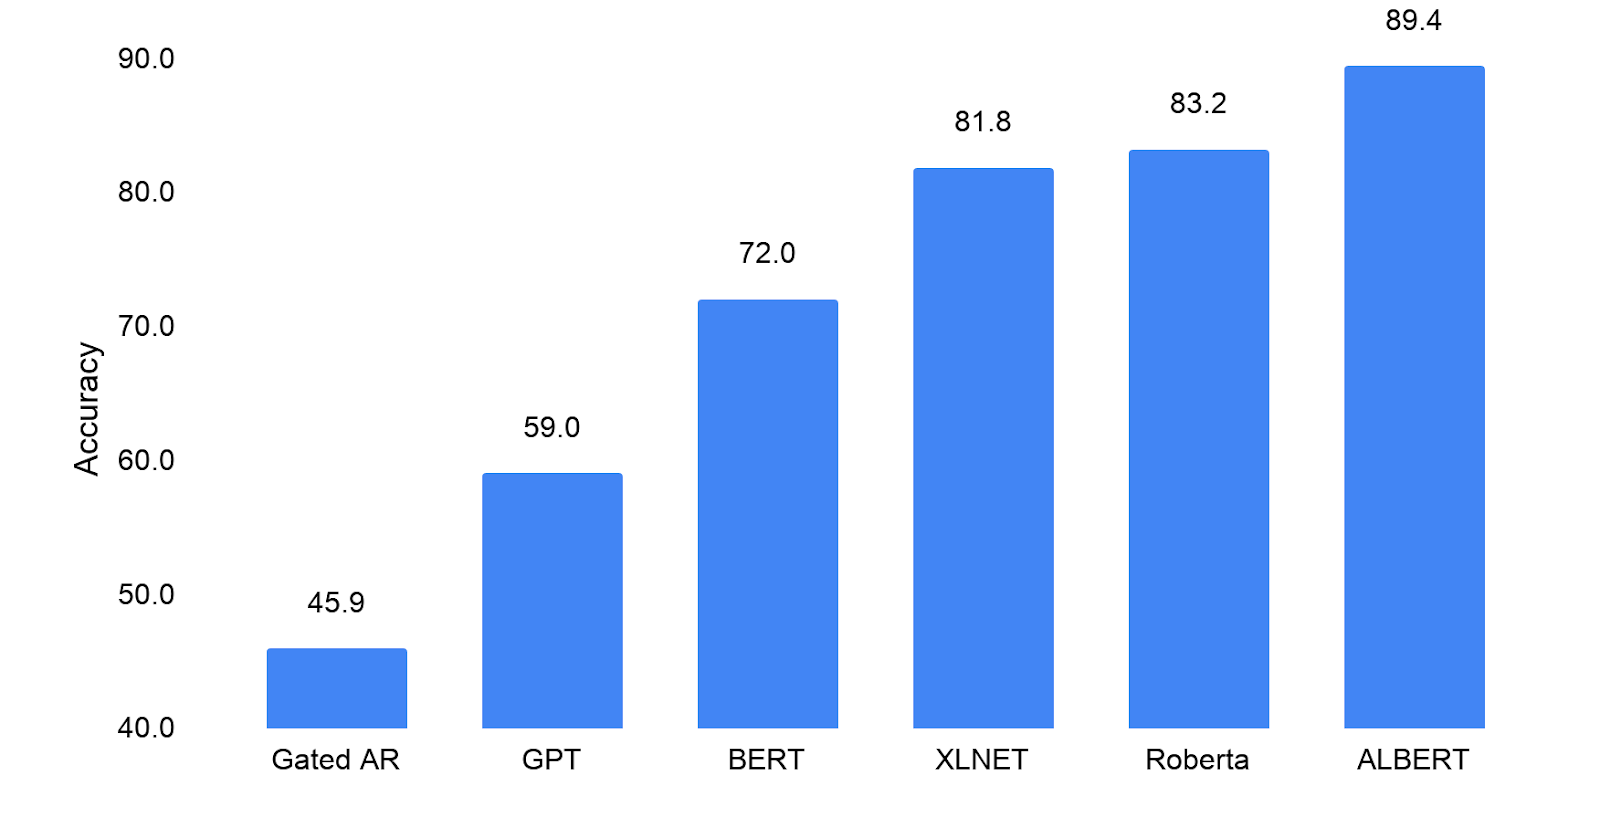

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [ ]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

#Fine-tuning
 
Let’s make BERT usable for text classification! We’ll load the model and attach a couple of layers on it:

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [ ]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:04, 3163.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
700it [00:00, 3160.40it/s]


max seq_len 38


In [ ]:
data.train_x.shape

(13784, 38)

In [ ]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [ ]:
data.train_y[0]

0

In [ ]:
data.max_seq_len

38

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7281a2c550> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=64,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


194/194 [==============================] - 4997s 26s/step - loss: 0.6950 - acc: 0.7583 - val_loss: 0.0687 - val_acc: 0.9862
Epoch 2/5
194/194 [==============================] - 5026s 26s/step - loss: 0.0753 - acc: 0.9804 - val_loss: 0.0475 - val_acc: 0.9884
Epoch 3/5
194/194 [==============================] - 5129s 26s/step - loss: 0.0498 - acc: 0.9860 - val_loss: 0.0529 - val_acc: 0.9891
Epoch 4/5
194/194 [==============================] - 5107s 26s/step - loss: 0.0351 - acc: 0.9906 - val_loss: 0.0406 - val_acc: 0.9891
Epoch 5/5
194/194 [==============================] - 5098s 26s/step - loss: 0.0255 - acc: 0.9927 - val_loss: 0.0407 - val_acc: 0.9906


## Evaluation

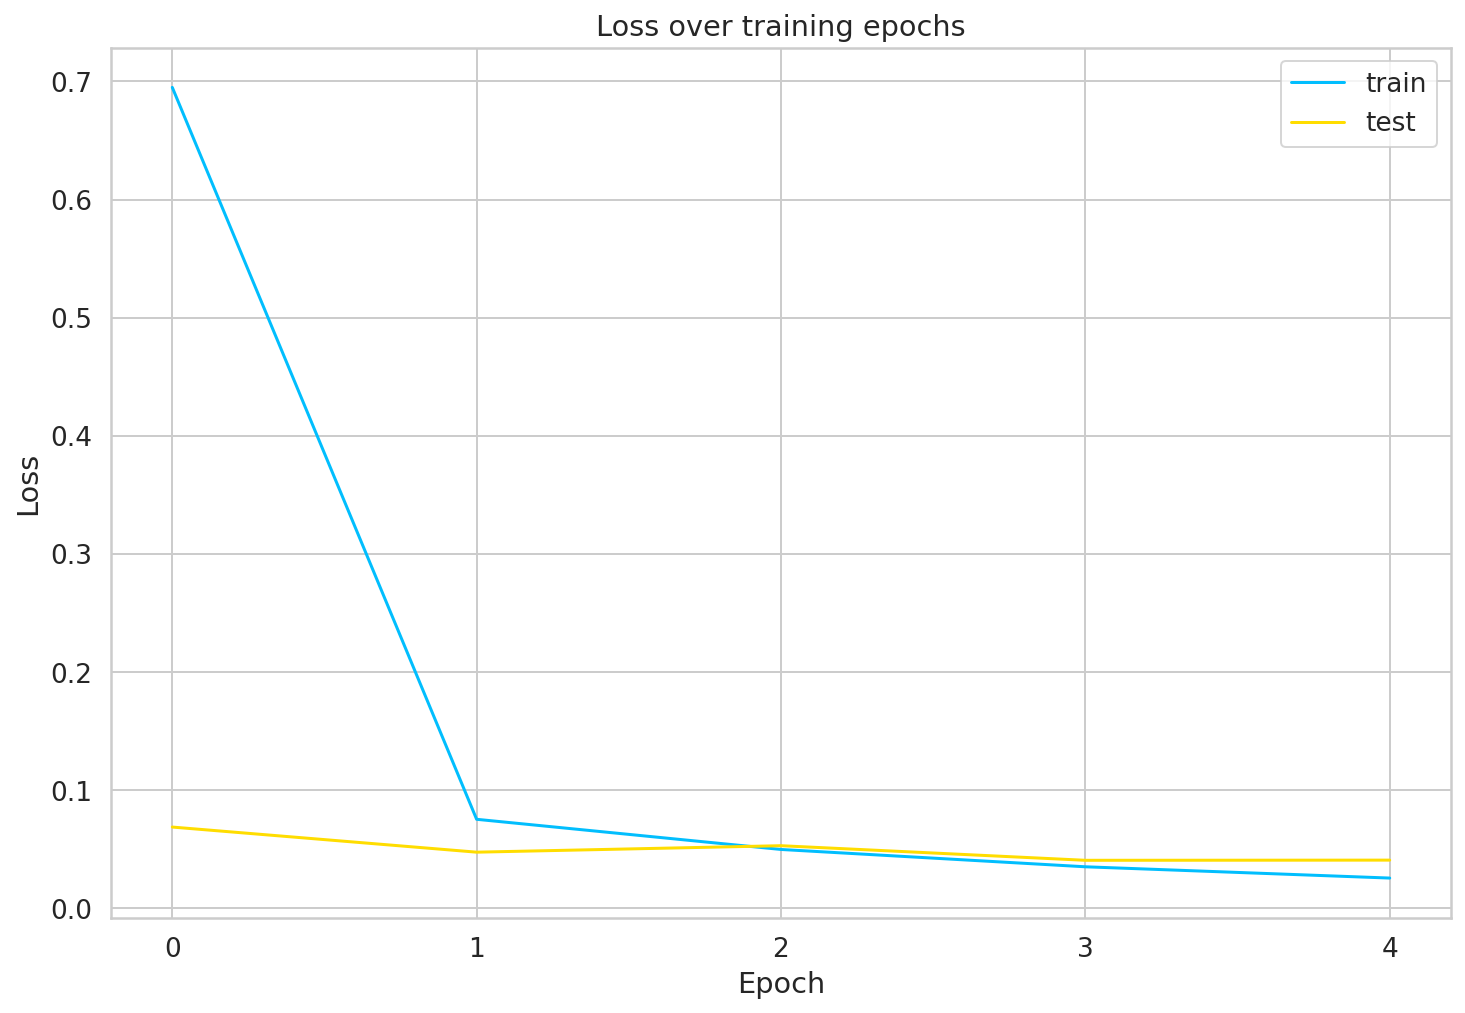

In [ ]:
# Loss over training epochs

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

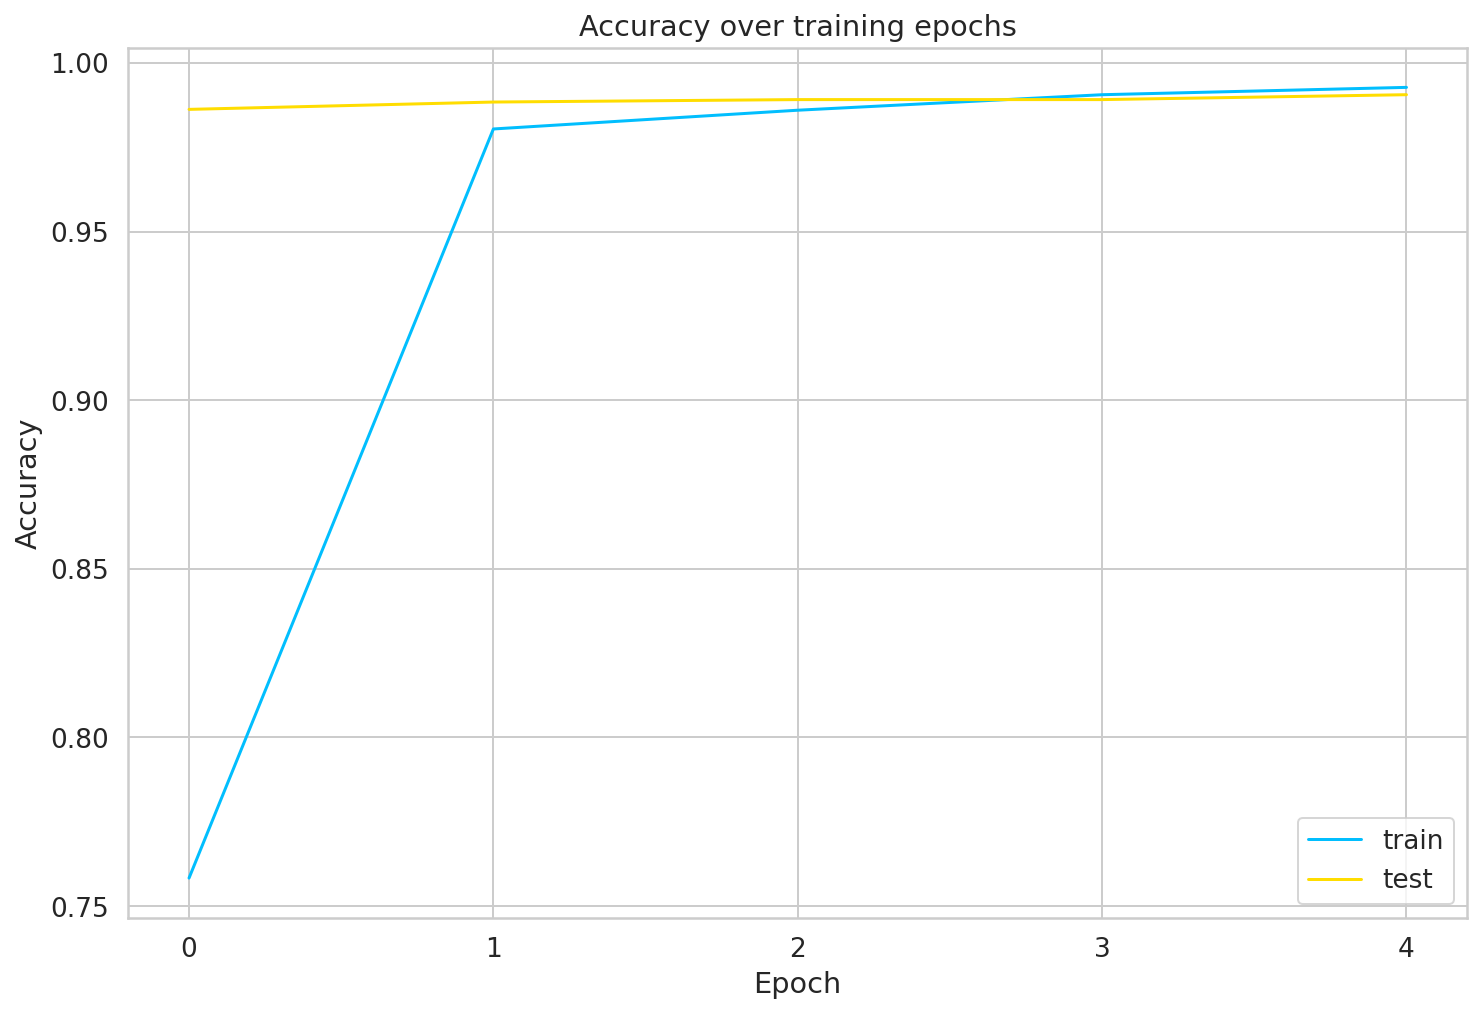

In [ ]:
# Accuracy over training epochs

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

22/22 [==============================] - 88s 4s/step - loss: 0.0752 - acc: 0.9771
train acc 0.996590256690979
test acc 0.977142870426178


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.95      1.00      0.97        86
       AddToPlaylist       1.00      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       0.97      0.93      0.95       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       0.99      0.99      0.99       104
  SearchCreativeWork       0.94      0.93      0.93       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

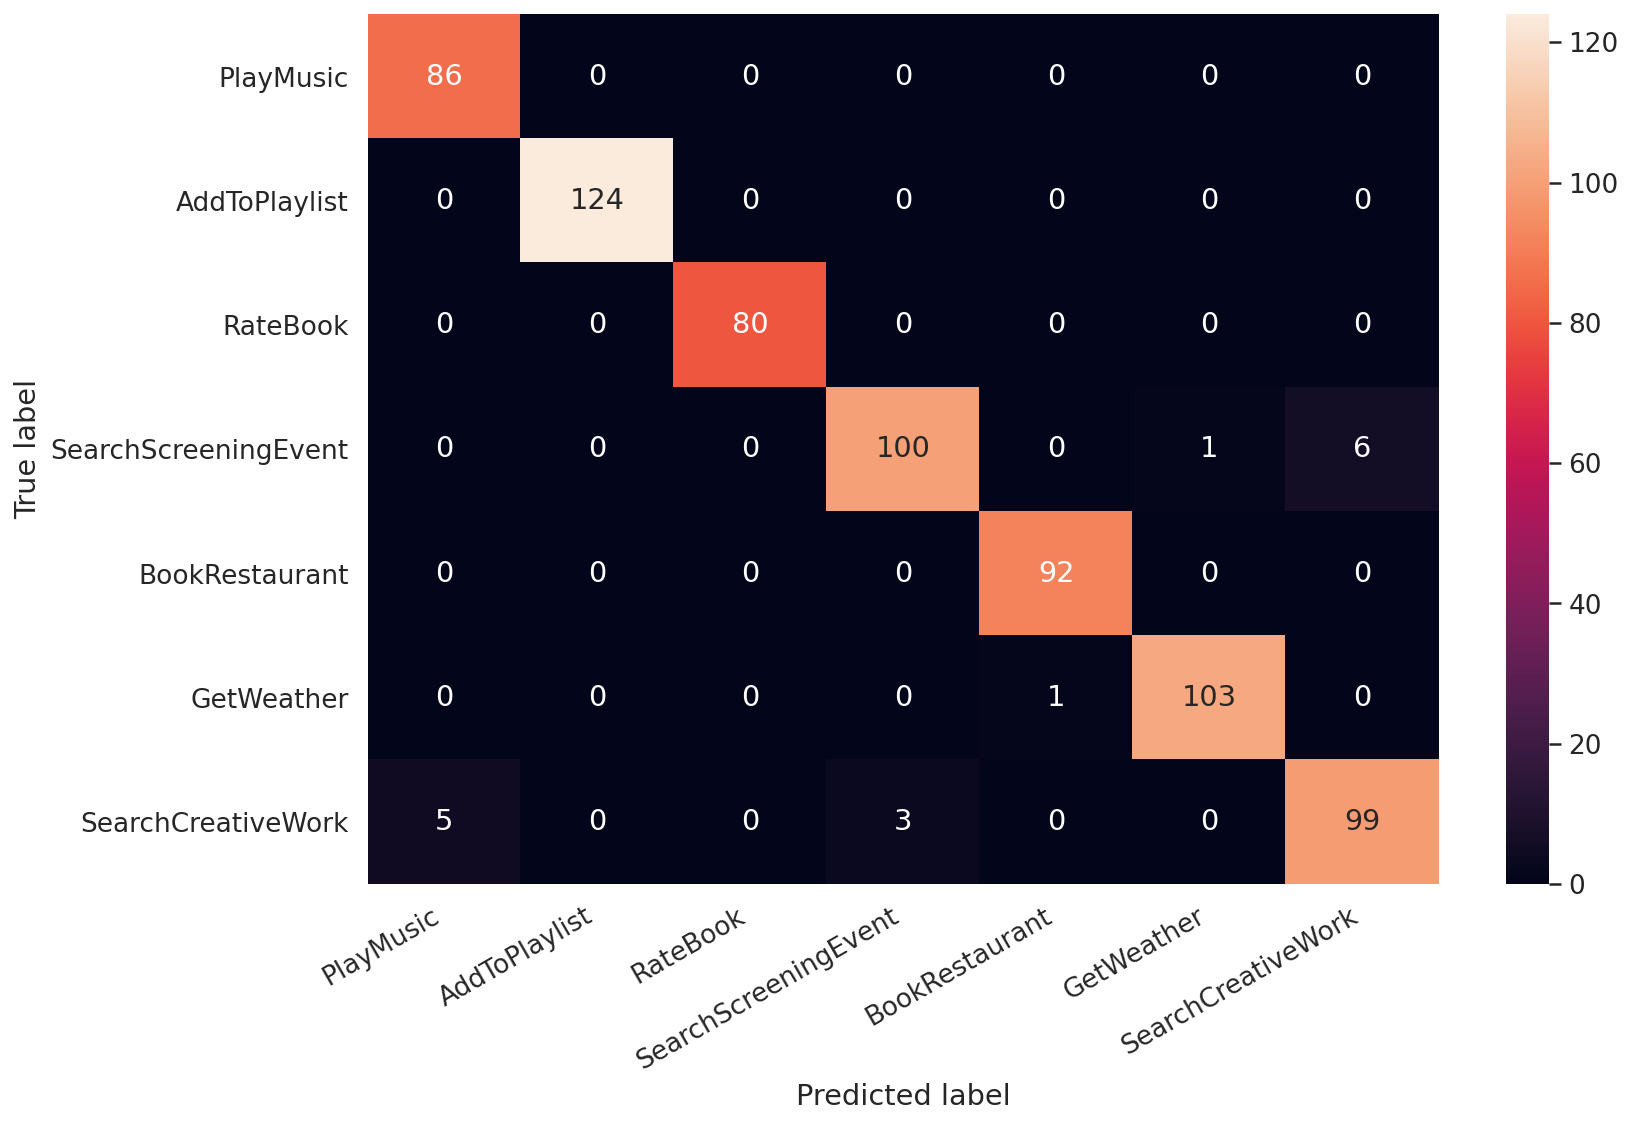

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
sentences = ["Play our rap",
  "Rate this book as awful",
  "listen to westbam alumb allergic on google music","Temperature outside"]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our rap 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook

text: listen to westbam alumb allergic on google music 
intent: PlayMusic

text: Temperature outside 
intent: GetWeather

